In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud , STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , roc_curve ,auc , mean_squared_error
from sklearn.decomposition import TruncatedSVD , PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
tf.config.list_physical_devices('GPU')

[]

In [2]:
train_df = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv',index_col='id', engine='python')

In [3]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
test_df = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv',index_col='id', engine='python')

In [ ]:
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...
...,...
7194635,He should lose his job for promoting mis-infor...
7194636,"""Thinning project is meant to lower fire dange..."
7194637,I hope you millennials are happy that you put ...


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                            

In [7]:
train_df.isnull().sum()

target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

No Null values for target and comment_text columns , so good to go

In [8]:
print(f'Train shape {train_df.shape}')

Train shape (1804874, 44)


In [9]:
print(f'Test shape {test_df.shape}')

Test shape (97320, 1)


# Exploratory Data Analysis:

## Target Feature:

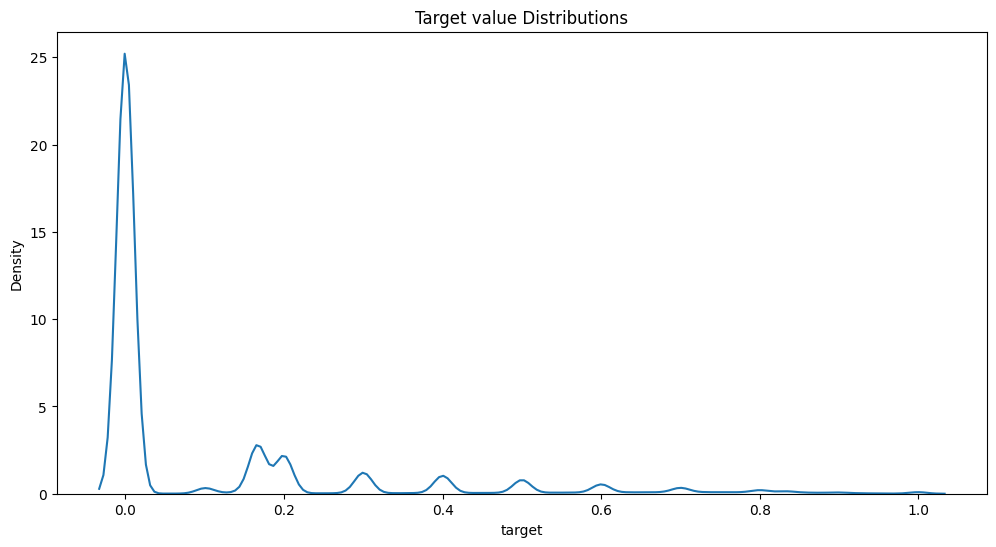

In [10]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'] , kde=True, hist=False , bins=240 , label='target')
plt.show()

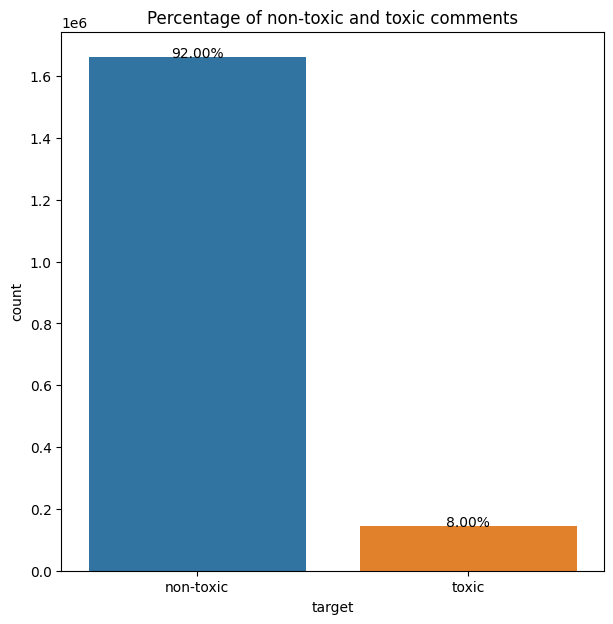

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
total = float(len(temp))

# Plot count plot
cntplot = sns.countplot(x=temp, ax=ax)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it in the plot itself
for p in cntplot.patches:  # Corrected from ax.patches
    height = p.get_height()
    cntplot.text(p.get_x() + p.get_width() / 2.0, height + 3,  
                 '{:1.2f}%'.format(100 * height / total),  
                 ha='center')

plt.show()


### The dataset is highly imbalanced as 92% of comments are non-toxic and only 8% are toxic

## 2. Toxicity Subtype Features

1. Severe_toxicity
2. obscene
3. threat
4. insult
5. identity_attack

In [12]:
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.histplot(data[feature], kde=True, label=feature, element="step")
    plt.xlabel('')
    plt.legend()
    plt.show()


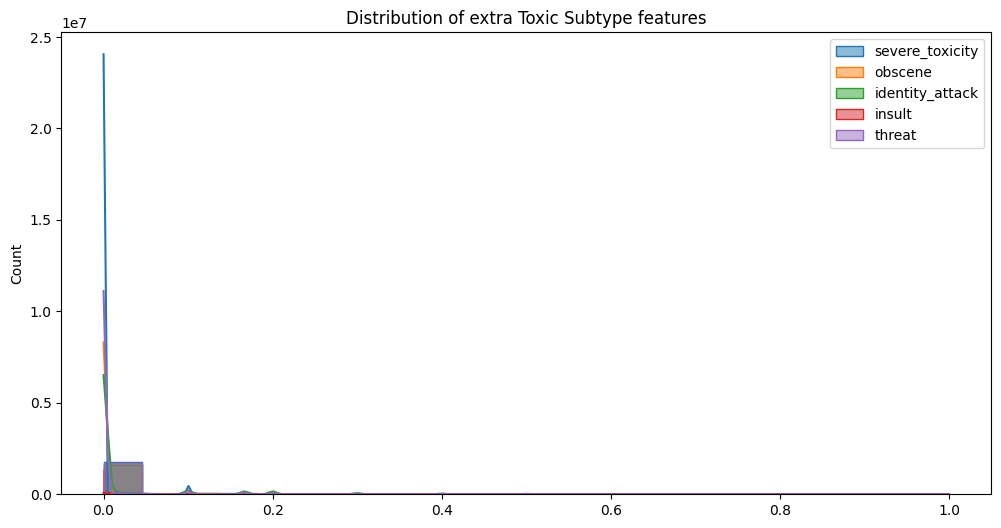

In [13]:
features=['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features , "Distribution of extra Toxic Subtype features" , train_df )

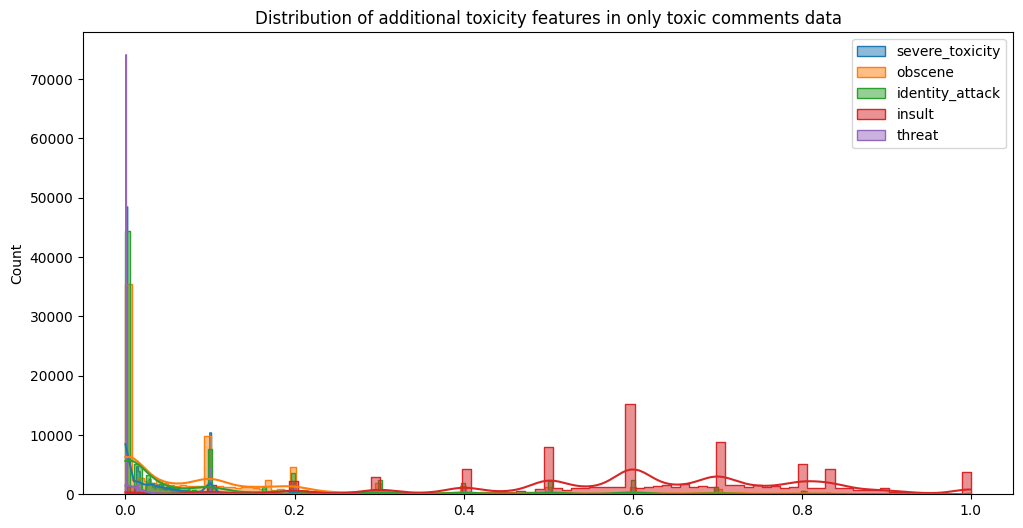

In [14]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

Insulting comment count is more than obscene for toxic comment

In [15]:
#getting the count of additional toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    #extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]

    maxarg = np.argmax(np.array(row)) #max value index

    if maxarg == 0: return 'severe_toxicity'
    elif maxarg==1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else : return 'threat'
    

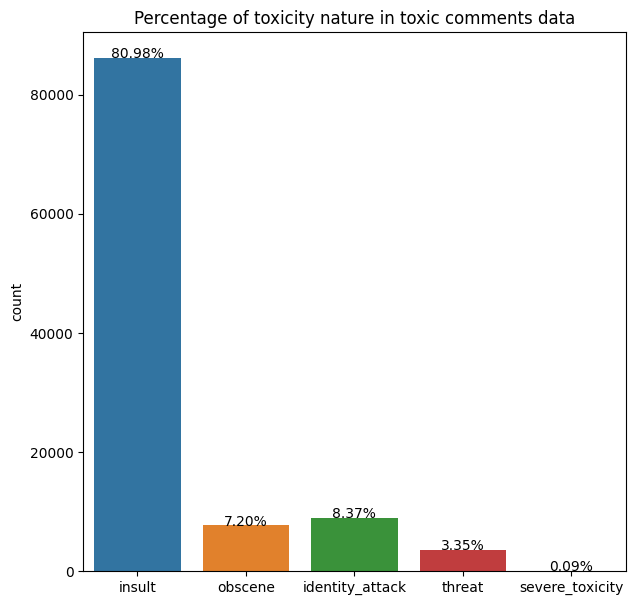

In [16]:
x = temp.apply(get_comment_nature , axis=1) #get nature of each toxic comment
fig , ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

#plot the count plot
cntplot = sns.countplot(x=x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

for p in cntplot.patches:  # Corrected from ax.patches
    height = p.get_height()
    cntplot.text(p.get_x() + p.get_width() / 2.0, height + 3,  
                 '{:1.2f}%'.format(100 * height / total),  
                 ha='center')

plt.show()

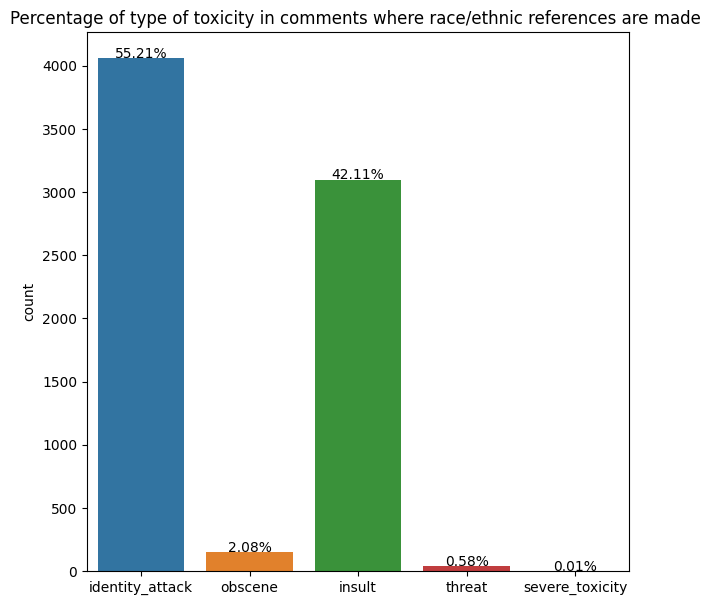

In [17]:
#get the data where race/ethnic references are made
cond = (train_df['asian']>0.5) | (train_df['black']>0.5) | (train_df['jewish'] > 0.5) | (train_df['latino']>0.5) | (train_df['white']>0.5) 
temp = train_df[cond]
temp = temp[temp['target'] > 0.5] #extracting only toxic comment

x = temp.apply(get_comment_nature , axis=1)

fig , ax = plt.subplots(1,1, figsize=(7,7))
total = float(len(x))

cntplot = sns.countplot(x=x)
cntplot.set_title("Percentage of type of toxicity in comments where race/ethnic references are made ")


for p in cntplot.patches:  # Corrected from ax.patches
    height = p.get_height()
    cntplot.text(p.get_x() + p.get_width() / 2.0, height + 3,  
                 '{:1.2f}%'.format(100 * height / total),  
                 ha='center')

plt.show()



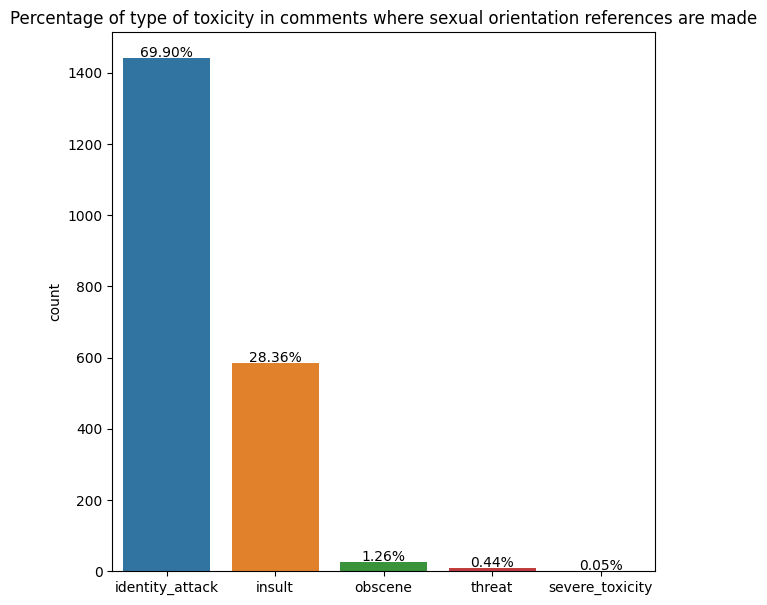

In [18]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x=x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in cntplot.patches:  # Corrected from ax.patches
    height = p.get_height()
    cntplot.text(p.get_x() + p.get_width() / 2.0, height + 3,  
                 '{:1.2f}%'.format(100 * height / total),  
                 ha='center')

plt.show()

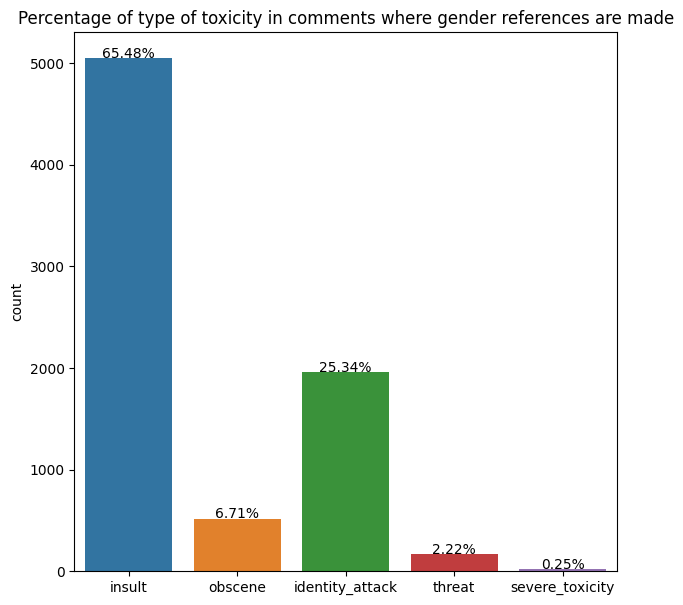

In [19]:
# Get data where gender eferences are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x=x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in cntplot.patches:  # Corrected from ax.patches
    height = p.get_height()
    cntplot.text(p.get_x() + p.get_width() / 2.0, height + 3,  
                 '{:1.2f}%'.format(100 * height / total),  
                 ha='center')

plt.show()

## comments_text feature

In [20]:
stpwrds = set(STOPWORDS)

def show_wordcloud(data , title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stpwrds,
        max_words = 50,
        max_font_size = 40,
        scale=5,
        random_state = 1
    ).generate(str(data))

    fig = plt.figure(1 , figsize=(10,10))
    plt.axis('off')
    if title:
        fig.suptitle(title , fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

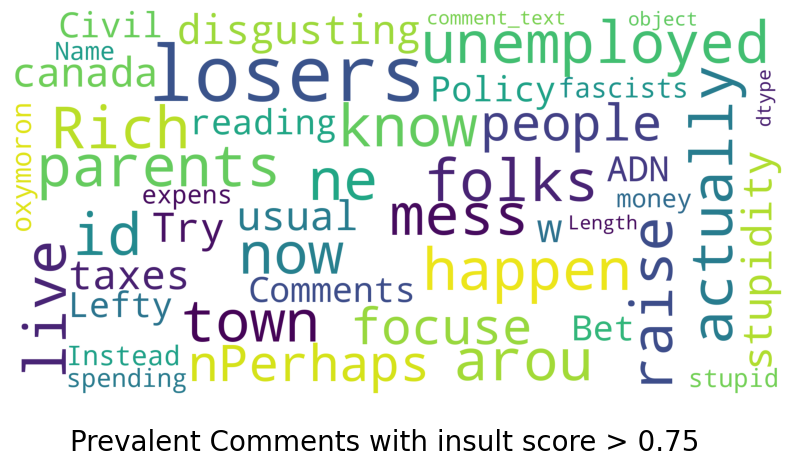

In [21]:
show_wordcloud(train_df.loc[train_df['insult']>0.75]['comment_text'].sample(20000),
              title = 'Prevalent Comments with insult score > 0.75')

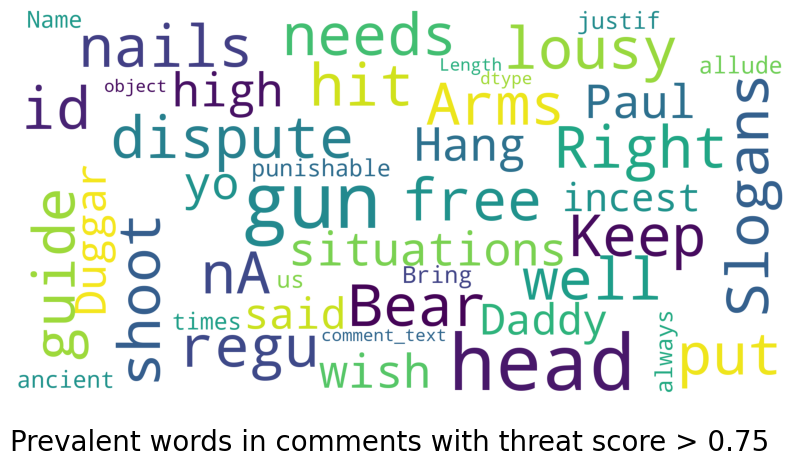

In [22]:
show_wordcloud(train_df.loc[train_df['threat']>0.75]['comment_text'],
              title="Prevalent words in comments with threat score > 0.75")

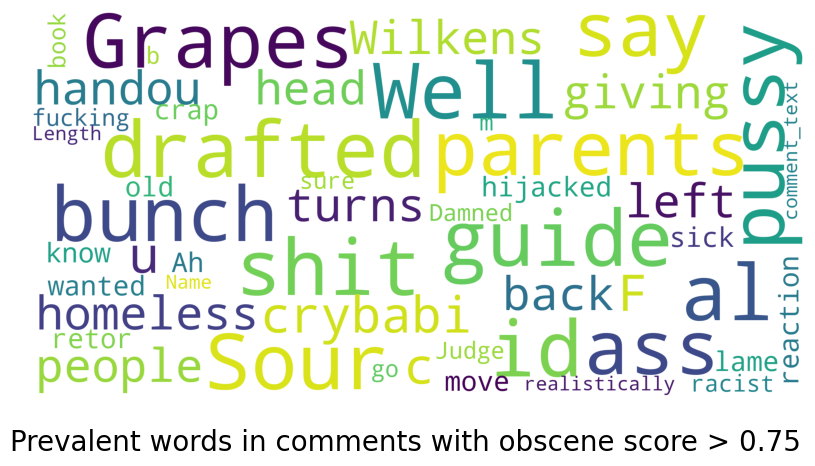

In [23]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'],
              title = 'Prevalent words in comments with obscene score > 0.75')

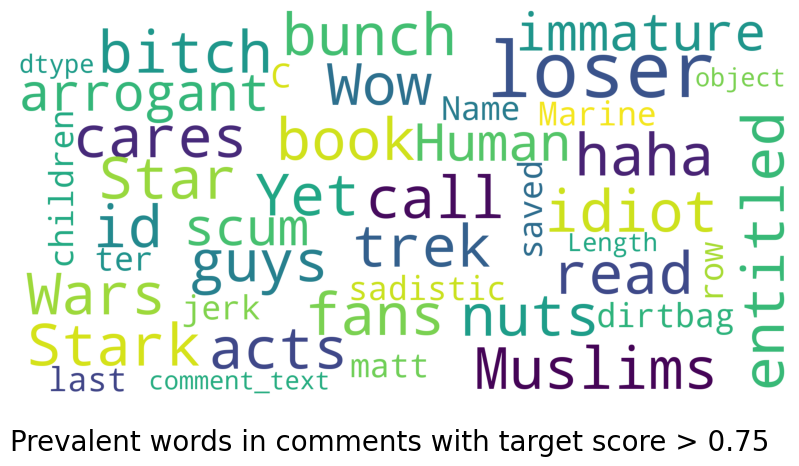

In [24]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

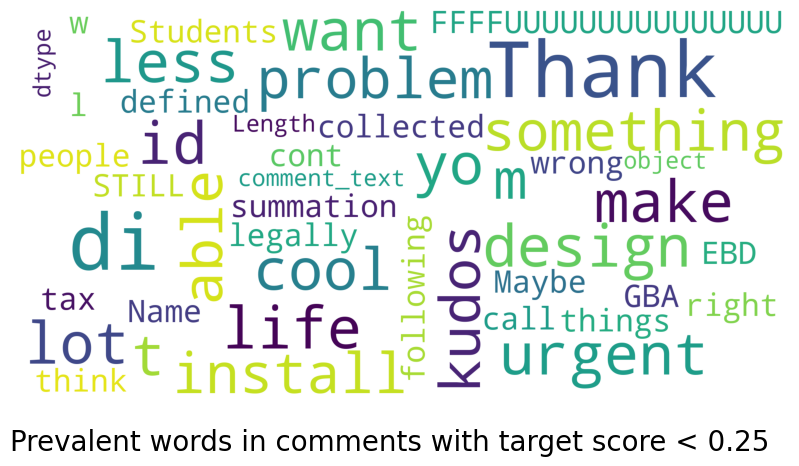

In [25]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

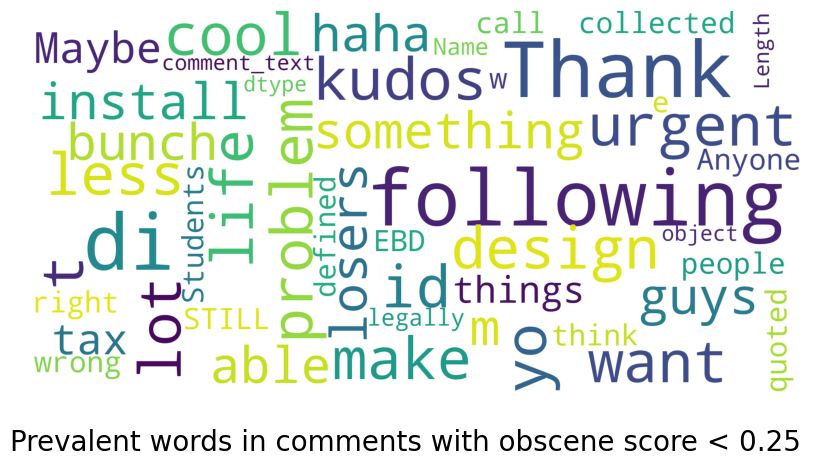

In [26]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

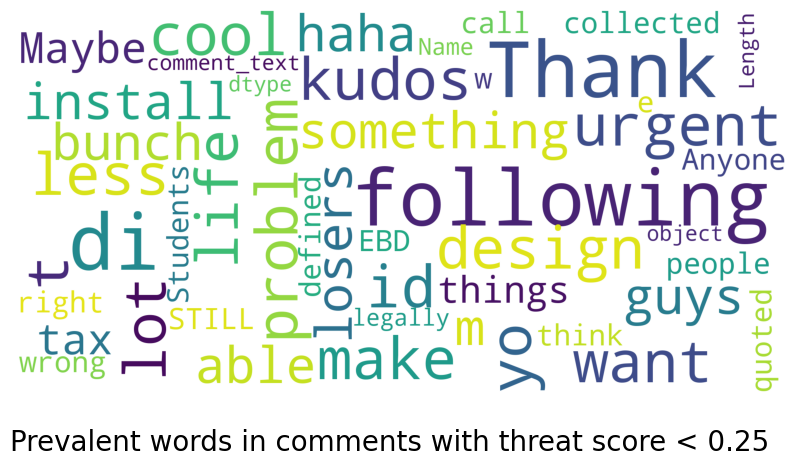

In [27]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

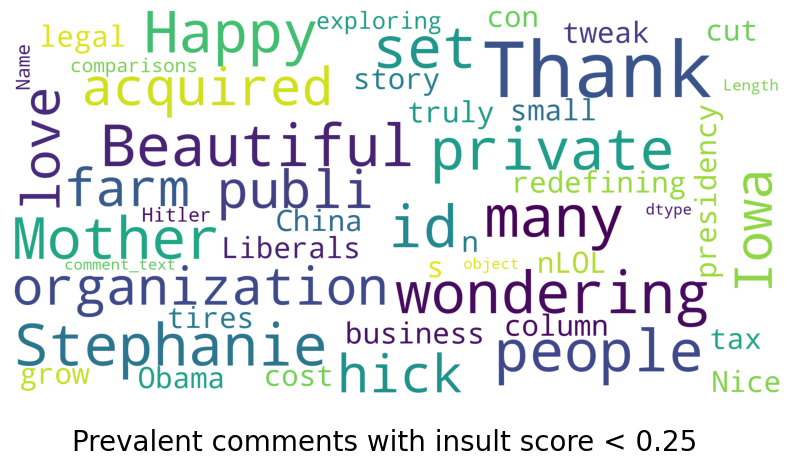

In [28]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

# Preprocessing text and train-test split

In [29]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def preprocess(text_string):
    if not isinstance(text_string, str):  # Handle non-string values
        return ""
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special character
    text_string = text_string.lower()

    x = text_string.split()
    new_text = []

    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))

    text_string = ' '.join(new_text)
    return text_string

In [30]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: user 11min 29s, sys: 38.4 ms, total: 11min 29s
Wall time: 11min 31s


In [31]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [32]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 36.9 s, sys: 1.93 ms, total: 36.9 s
Wall time: 37 s


In [33]:

X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [34]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [35]:
X_train.head()

,preprocessed_text
id,
5225944,good final sentenc tabbi grammar let sure pink...
6182940,houston right lol lol lol lol lol lol lol lol ...
5970336,continu misconstru point franklin segment viab...
5396472,understand ralli anti sharia law anti islam tw...
616267,hear trump say xl go approv nutley cost polici


In [36]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

In [37]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

# Training Models:

## 1. Bag of Words (BoW):

In [38]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


## 1.1 SGD Regressor:

## 1.1.1 Hyperparameter Tuning

In [39]:
# performing hyperparameter tuning:
alpha = [0.00001 , 0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors =[]
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")

        model = SGDRegressor(alpha=a , penalty=p)
        model.fit(bow_train , y_train)

        preds = model.predict(bow_train)
        err = mean_squared_error(y_train['target'], preds) #calculate error on transit
        tr_errors.append(err)
        print("Mean squared Error on train set: ", err)

        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'] , preds)
        cv_errors.append(err)
        print("Mean squared Error on cv set: ", err)

        if err< best_error:
            best_error = err
            best_model = model

        print("*"*50)

1e-05 l1 :
Mean squared Error on train set:  0.2550934270908936
Mean squared Error on cv set:  0.03259144294703534
**************************************************
1e-05 l2 :
Mean squared Error on train set:  0.8256788861603798
Mean squared Error on cv set:  0.056713031611567224
**************************************************
0.0001 l1 :
Mean squared Error on train set:  0.0244804528337291
Mean squared Error on cv set:  0.024476522638323034
**************************************************
0.0001 l2 :
Mean squared Error on train set:  2.8277046234834526
Mean squared Error on cv set:  0.6099365949724485
**************************************************
0.001 l1 :
Mean squared Error on train set:  0.03145130879529095
Mean squared Error on cv set:  0.031431573118127415
**************************************************
0.001 l2 :
Mean squared Error on train set:  0.03367452954996966
Mean squared Error on cv set:  0.024015964652156628
************************************************

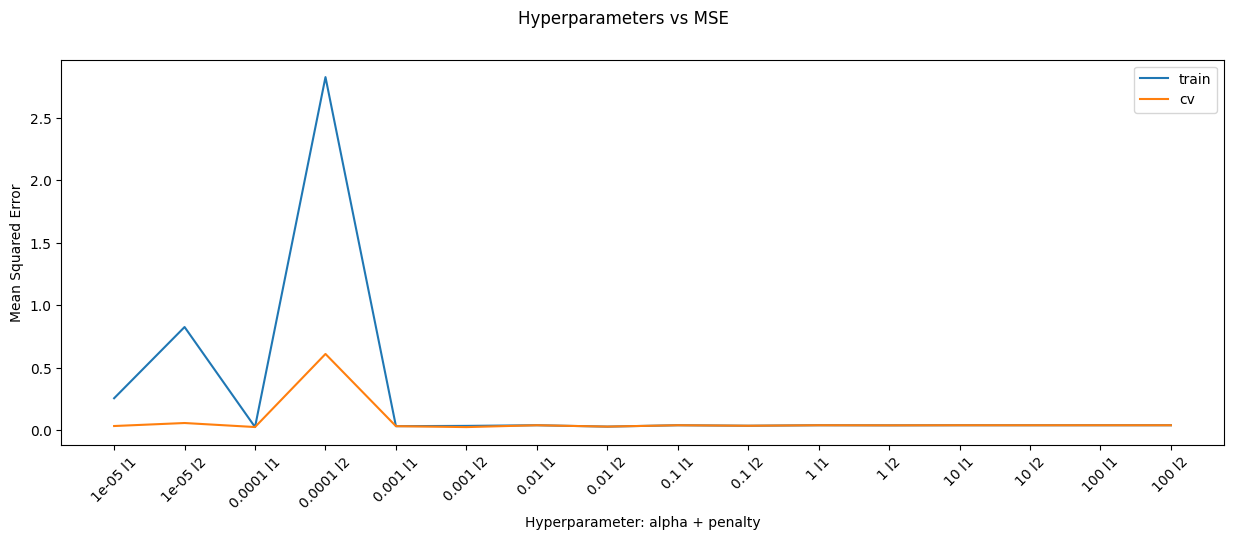

In [40]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [41]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 0.001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## 1.1.2 Feature Importance:

In [42]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
great great,0.818850
idiot,0.386471
stupid,0.333645
moron,0.243129
pathet,0.240831
hypocrit,0.223869
crap,0.221093
dumb,0.217453
fool,0.188858
clown,0.188731


In [43]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
stupid stupid,-0.060147
left left,-0.055189
left,-0.036442
black white,-0.030528
america great,-0.027005
fool peopl,-0.026189
ignor fact,-0.025516
knee jerk,-0.024472
white hous,-0.023932
great articl,-0.023107


## 1.2 Decision Trees:

## 1.2.1 Hyperparameter Tuning


In [44]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03309826529838335
Mean Squared Error on cv set:  0.03314638893717833
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03309826529838335
Mean Squared Error on cv set:  0.03314638893717833
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.033100837175232226
Mean Squared Error on cv set:  0.033145654550950004
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.032007128127851
Mean Squared Error on cv set:  0.032086619396969225
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03200946933868882
Mean Squared Error on cv set:  0.03208418313760966
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train

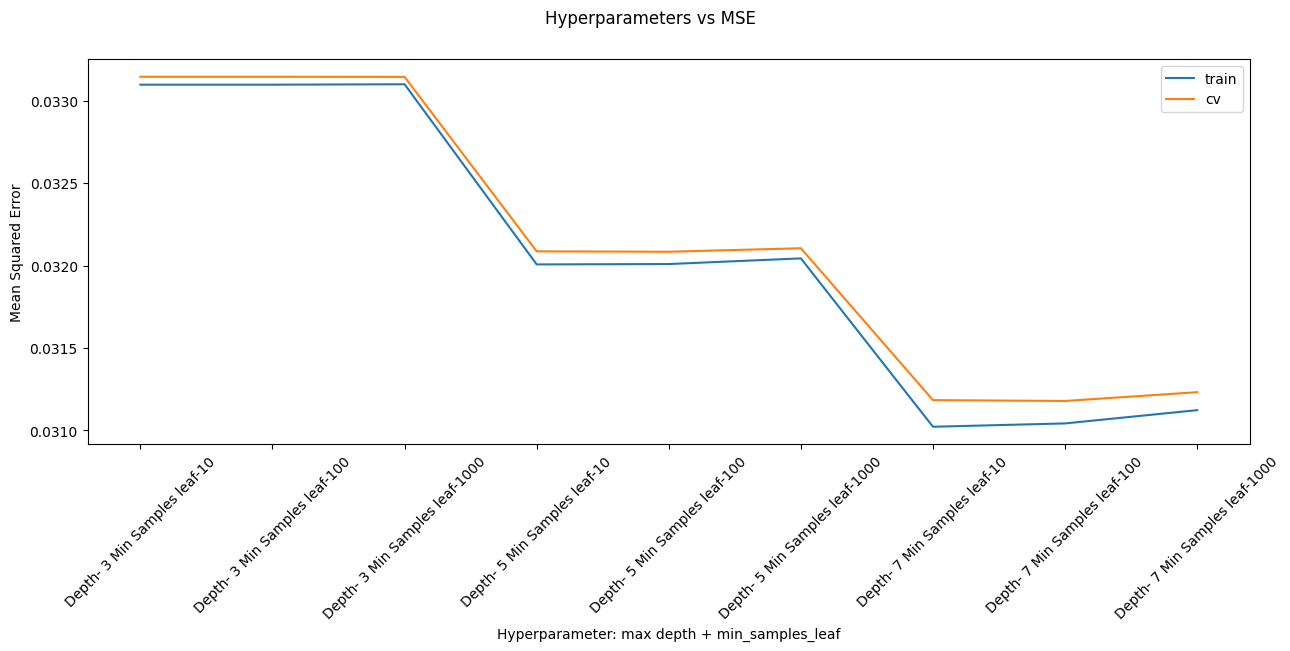

In [45]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [46]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## 1.2.2 Feature Importance:

In [47]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.395818
idiot,0.264895
fool,0.070217
pathet,0.068445
moron,0.063503
racist,0.060097
hypocrit,0.055806
would,0.004092
year,0.003819
one,0.003748


# 2. Term Frequency - Inverse Document Frequency (TFIDF)

In [48]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


## 2.1 SGD Regressor:

## 2.1.1 Hyperparameter Tuning:

In [49]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.02527401273959694
Mean Squared Error on cv set:  0.02525725319016758
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.023916266624307826
Mean Squared Error on cv set:  0.023953180213097346
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.02972994657407858
Mean Squared Error on cv set:  0.029694383223430414
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.025026327643229845
Mean Squared Error on cv set:  0.025059602865021794
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.038306257090284096
Mean Squared Error on cv set:  0.038300305395300105
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.03006180533131219
Mean Squared Error on cv set:  0.030080042108158508
***************************************

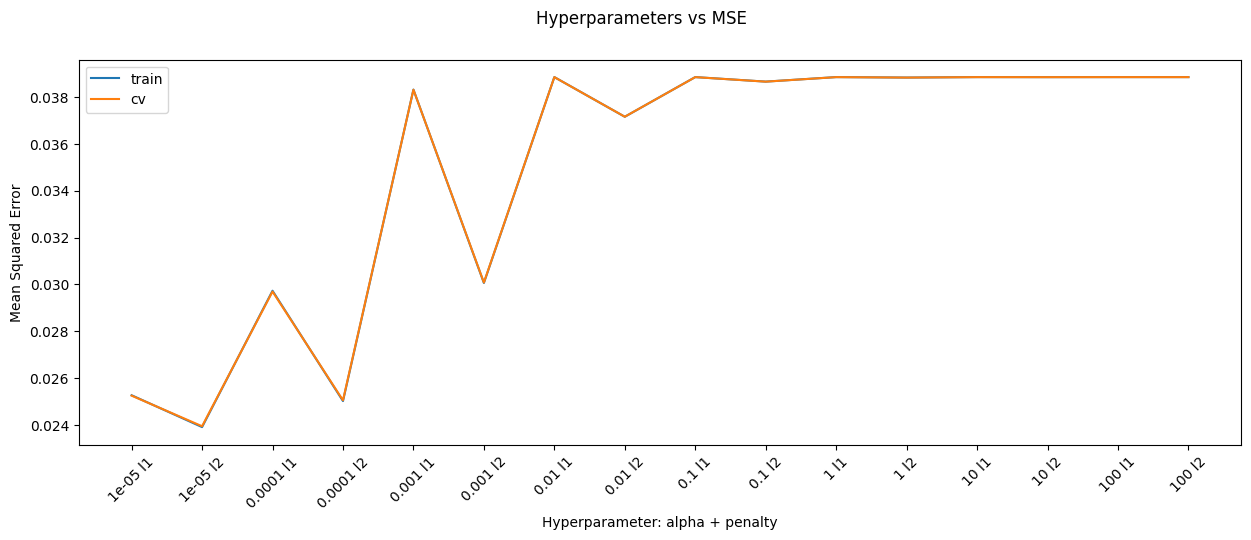

In [50]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

## 2.1.2 Feature Importance:

In [51]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.562841
idiot,1.264696
fool,0.663771
ignor,0.602509
dumb,0.591485
pathet,0.586579
moron,0.570535
ridicul,0.559665
loser,0.559201
liar,0.522342


In [52]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.094897
interest,-0.087622
stori,-0.076212
great,-0.074798
agre,-0.074797
may,-0.071316
new,-0.069886
good,-0.069787
point,-0.067084
com,-0.066472


## 2.2 Decision Trees:

## 2.2.1 Hyper Parameter tuning

In [53]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03289216804686802
Mean Squared Error on cv set:  0.03293561220727496
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03289216804686802
Mean Squared Error on cv set:  0.03293561220727496
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03289216804686802
Mean Squared Error on cv set:  0.03293561220727496
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03174829868715204
Mean Squared Error on cv set:  0.03180349658815436
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03174980593641413
Mean Squared Error on cv set:  0.03180576507798283
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train 

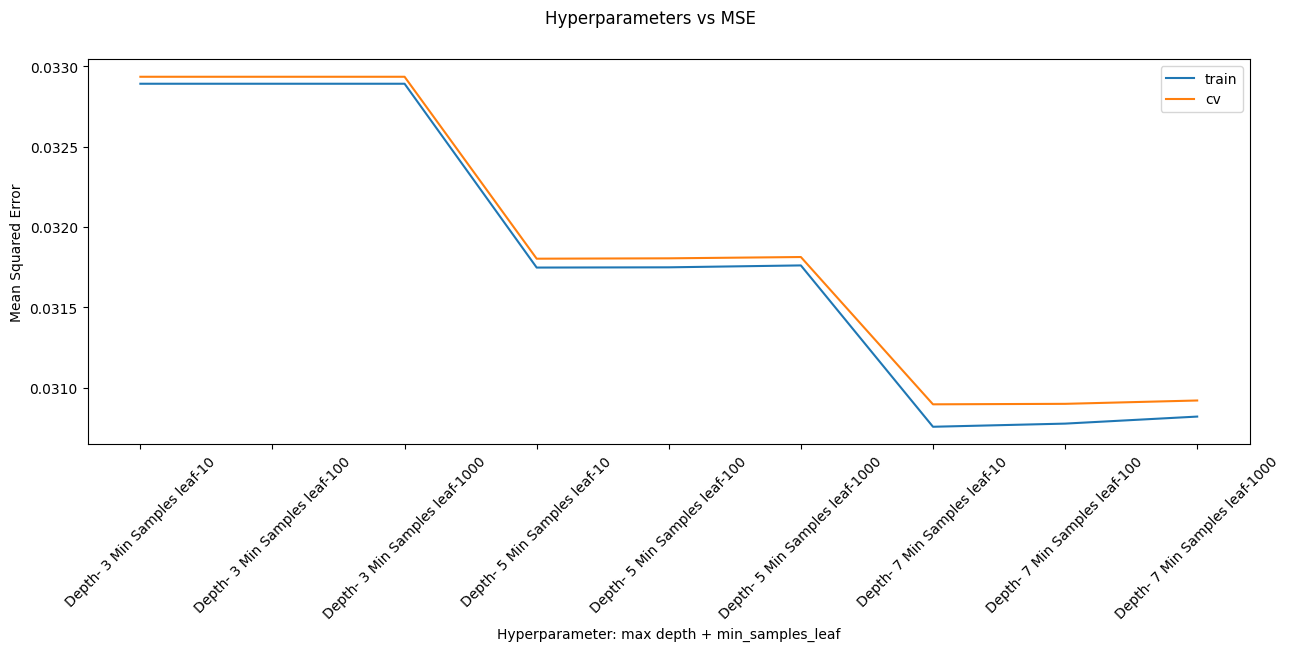

In [54]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

## 2.2.2 Feature Importance:

In [55]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.404735
idiot,0.268653
fool,0.073438
pathet,0.070110
moron,0.064010
racist,0.058393
hypocrit,0.053946
white,0.001916
ignor,0.000997
fool peopl,0.000921


# 3. Features for LSTM

In [56]:
class LSTMFeaturization:

    def __init__(self):
        self.word_mapping = None
        self.total_words = None

    #accepts a list of sentences and builds a vocabulary
    def build_vocabulary(self , sentences):

        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)

        #create a dictionary from vocabulary
        vocab_dict = dict.fromkeys(vocab , 0)

        #calculate count of each word...
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1

        return vocab_dict

    #accepts a dictionary (vocabulary ) and gets the word number in dictionary form
    def get_mapping(self , vocab_dict):
        #get number of each word into the corpus
        k=[]
        v=[]
        for keys , val in vocab_dict.items():
            k.append(keys)
            v.append(val)

        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=['Word' , 'Count'], data=kv)
        df['Count'] = df['Count'].astype('int')

        #sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False , inplace=True)

        #give numbering to most frequent word as 1 then next as 2 and so on
        df.reset_index(inplace = True)
        df['mapping'] = df.index + 1

        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace = True)

        #convert to dictionary for easier processing
        dictionary = dict(zip(df['Word'], df['mapping']))

        return dictionary

    def fit(self , sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)

    def transform(self, sentences, pad_length=350):
        whole = []
        for sentence in sentences:
            part = []
            for word in sentence.split():  # Loop through words in sentence
                if word in self.word_mapping:
                    part.append(self.word_mapping[word])
            whole.append(part)
    
        whole = keras.preprocessing.sequence.pad_sequences(whole, maxlen=pad_length)
        return whole


In [57]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [58]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [59]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [60]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_vecor_length = 100
total_words = lstmfeat.total_words

model = Sequential()
model.add(Embedding(total_words + 1, embedding_vecor_length, input_length=350))
model.add(LSTM(128, return_sequences=True))  # Use LSTM instead of CuDNNLSTM
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, 350))  # Explicitly set input shape
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 350, 100)            │      20,165,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 350, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,414,561 (77.88 MB)

 Trainable params: 20,414,561 (77.88 MB)

 Non-trainable params: 0 (0.00 B)

None


In [62]:
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [63]:
import numpy as np

print("Train Shape:", lstm_train.shape, y_train.shape)
print("CV Shape:", lstm_cv.shape, y_cv.shape)

print("NaN in lstm_train:", np.isnan(lstm_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())


Train Shape: (1353655, 350) (1353655, 1)
CV Shape: (451219, 350) (451219, 1)
NaN in lstm_train: 0
NaN in y_train: target    0
dtype: int64


In [ ]:
import numpy as np

# Ensure inputs are NumPy arrays
lstm_train = np.array(lstm_train)
y_train = np.array(y_train)
lstm_cv = np.array(lstm_cv)
y_cv = np.array(y_cv)

# Restart kernel before training to avoid duplicate model builds
history = model.fit(lstm_train, y_train, 
                    epochs=2,  
                    batch_size=1024, 
                    validation_data=(lstm_cv, y_cv), 
                    verbose=1, 
                    callbacks=callbacks_list)


Epoch 1/2
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0410 - mse: 0.0410
Epoch 1: val_loss improved from -inf to 0.03873, saving model to weights-improvement-01-0.04.keras
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 13592s 10s/step - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 2/2
  63/1322 ━━━━━━━━━━━━━━━━━━━━ 3:13:48 9s/step - loss: 0.0380 - mse: 0.0380